In [15]:
# import required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.api as sm



In [21]:
## define funciton that fits poisson regression



# build model

def poissonR(X,Y,train):
    '''
    inputs:
        X: explanatory variables (dataframe)
        Y: output variable (dataframe)
        train: do training or not (boolean)
        
    outputs:
        parameters: possion regressor parameters
        intercept: value of independetn term (y intercept), 
        coefficients: coefficients of explanatory vairables (all linera)
        y_test: testing data
        predictions: predicted data
        stats : summary of statistics of the predictive power of the model
    
    
    '''
    
    # turn categorical into dummies
    X = pd.get_dummies(data=X, drop_first=True)

    # build model#poly = PolynomialFeatures(include_bias=False,interaction_only=True)
    pr = PoissonRegressor(alpha=0, max_iter=500, fit_intercept=True)
    
    # fit model
    pr.fit(X, Y)
    parameters=pr.get_params()
    intercept=pr.intercept_
    coefficients= pd.DataFrame(pr.coef_,X.columns,columns=['Coefficient'])
    
    y_train=0
    predictions=0 
    stats=0
    
    if train==1:
        
        # split data into train and test (test_size specifies %)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
        
        # fit training
        pr.fit(X_train,y_train)
        
        # use model to predict
        predictions = pr.predict(X_test)

        X_train_Sm= sm.add_constant(X_train)
        ls=sm.OLS(y_train,X_train_Sm).fit()
        stats=ls.summary()
        return parameters, intercept, coefficients, y_test, predictions, stats
    else:
        return parameters, intercept, coefficients
    


In [22]:
## import data frames

fullData = pd.read_csv("data/31DayDataUpdate.csv")
myData = fullData[['Quarter', 'HB', 'CancerType','NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days']]
myData = myData.groupby(['Quarter', 'HB', 'CancerType']).sum().reset_index()

fullData = pd.read_csv("data/62DayDataUpdate.csv")
myData2 = fullData[['Quarter', 'HB', 'CancerType','NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days']]
myData2 = myData2.groupby(['Quarter', 'HB', 'CancerType']).sum().reset_index()

myData

,Quarter,HB,CancerType,NumberOfEligibleReferrals31DayStandard,NumberOfEligibleReferralsTreatedWithin31Days
0,2012Q1,S08000015,All Cancer Types,804,796
1,2012Q1,S08000015,Breast,176,176
2,2012Q1,S08000015,Cervical,10,10
3,2012Q1,S08000015,Colorectal,112,110
4,2012Q1,S08000015,Head & Neck,34,32
...,...,...,...,...,...
5540,2021Q3,S08000032,Lymphoma,56,56
5541,2021Q3,S08000032,Melanoma,70,70
5542,2021Q3,S08000032,Ovarian,30,30
5543,2021Q3,S08000032,Upper GI,106,106


In [23]:
## edit 31 days data

df=myData

# remove Nans
df = df[df['NumberOfEligibleReferrals31DayStandard'].notna()]
df = df[df['NumberOfEligibleReferralsTreatedWithin31Days'].notna()]

# remove 'all cancer types' from data
df = df[df['CancerType'] != 'All Cancer Types']

# add a numerical variable 1-1 to quarters and an index variable before/after pandemic
quarters=df['Quarter']
quars=df['Quarter'].unique()
dic = {}
for i in range(len(quars)):
    dic[quars[i]]=i
dates=[dic[key] for key in quarters]
pandemic = dates.copy()
pandemic = [0 if i < dic['2020Q1'] else (i-dic['2020Q1']) for i in pandemic]        

df['Date'] =dates
df['Pandemic'] =pandemic

df.to_csv('../../31DayDataModified.csv', index=False)

## do the same with 62 days data

df1=myData2
df1 = df1[df1['NumberOfEligibleReferrals62DayStandard'].notna()]
df1 = df1[df1['NumberOfEligibleReferralsTreatedWithin62Days'].notna()]

df1 = df1[df1['CancerType'] != 'All Cancer Types']
df1 = df1[df1['HB'] != 'S92000003']

quarters=df1['Quarter']
quars=df1['Quarter'].unique()
dic = {}
for i in range(len(quars)):
    dic[quars[i]]=i
dates=[dic[key] for key in quarters]
pandemic = dates.copy()
pandemic = [0 if i < dic['2020Q1'] else (i-dic['2020Q1']) for i in pandemic]        

df1['Date'] =dates
df1['DateSquared'] = [i**2 for i in dates]
df1['Pandemic'] =pandemic

df1.to_csv('../../62DayDataModified.csv', index=False)


                                              NumberOfEligibleReferrals31DayStandard  \
NumberOfEligibleReferrals31DayStandard                                      1.000000   
NumberOfEligibleReferralsTreatedWithin31Days                                0.997441   
Date                                                                        0.015802   
Pandemic                                                                    0.001590   

                                              NumberOfEligibleReferralsTreatedWithin31Days  \
NumberOfEligibleReferrals31DayStandard                                            0.997441   
NumberOfEligibleReferralsTreatedWithin31Days                                      1.000000   
Date                                                                              0.013349   
Pandemic                                                                          0.005868   

                                                  Date  Pandemic  
NumberOfEligibleRefer

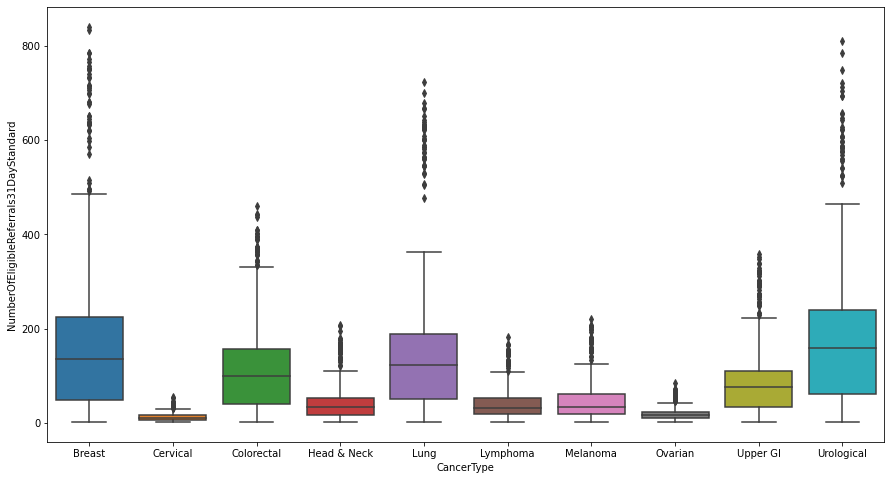

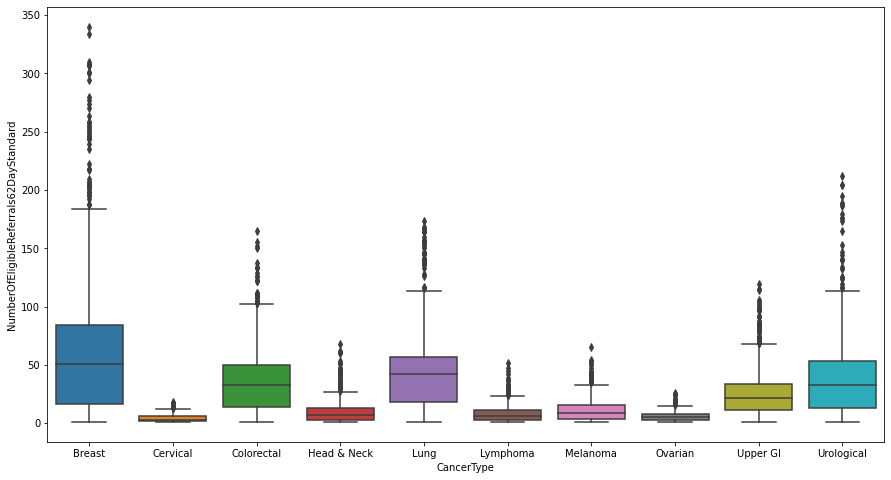

In [24]:
# take a look at what we have

print(df.corr())

print(df1.corr())

# plot eligibles per cancer type
plt.figure(figsize=(15,8))
ax =sns.boxplot(y='NumberOfEligibleReferrals31DayStandard',x='CancerType',data=df)
plt.show()

plt.figure(figsize=(15,8))
ax =sns.boxplot(y='NumberOfEligibleReferrals62DayStandard',x='CancerType',data=df1)
plt.show()

In [25]:
## BUILD GLMS 

# FOR 31 DAYS DATA

# choose explanatory variables
X0 = df[['Date','CancerType','HB']] # no pandemic
X0_p = df[['Pandemic','CancerType','HB']] # pandemic, no data
X0_dp = df[['Date','Pandemic','CancerType','HB']] # both
# choose output data
Y0 = df['NumberOfEligibleReferrals31DayStandard']
Y0t=df['NumberOfEligibleReferralsTreatedWithin31Days']


## FOR 62 DAYS DATA

# choose explanatory variables
X1 = df1[['Date','HB','CancerType']]#, 'CancerType', 'Sex']]
X1_p = df1[['Pandemic','CancerType','HB']]
X1_dp = df1[['Date','Pandemic','CancerType','HB']]
X1_d2 = df1[['Date','DateSquared','CancerType','HB']]
# choose output data
Y1 = df1['NumberOfEligibleReferrals62DayStandard']

Y1t=df1['NumberOfEligibleReferralsTreatedWithin62Days']




In [26]:
# choose data
X=X0
Y=Y0

# run poisson regression for chosen data
parameters, intercept, coefficients, y_test, predictions, stats = poissonR(X,Y,1)

/home/s2273096/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/s2273096/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [27]:
# take a look at results
print(intercept)

print(coefficients)


5.074205989996079
                        Coefficient
Date                       0.002496
CancerType_Cervical       -2.865865
CancerType_Colorectal     -0.394154
CancerType_Head & Neck    -1.440276
CancerType_Lung           -0.126721
CancerType_Lymphoma       -1.529211
CancerType_Melanoma       -1.361387
CancerType_Ovarian        -2.339264
CancerType_Upper GI       -0.674638
CancerType_Urological      0.051820
HB_S08000016              -1.208921
HB_S08000017              -0.789859
HB_S08000019              -0.266741
HB_S08000020               0.377174
HB_S08000022              -0.257728
HB_S08000024               0.731798
HB_S08000025              -3.272880
HB_S08000026              -2.824357
HB_S08000028              -2.505551
HB_S08000029              -0.140449
HB_S08000030               0.207816
HB_S08000031               1.298544
HB_S08000032               0.237757


/home/s2273096/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                                      OLS Regression Results                                      
Dep. Variable:     NumberOfEligibleReferrals31DayStandard   R-squared:                       0.705
Model:                                                OLS   Adj. R-squared:                  0.703
Method:                                     Least Squares   F-statistic:                     309.0
Date:                                    Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                                            17:31:39   Log-Likelihood:                -16761.
No. Observations:                                    2999   AIC:                         3.357e+04
Df Residuals:                                        2975   BIC:                         3.371e+04
Df Model:                                              23                                         
Covariance Type:                                nonrobust                                         
          

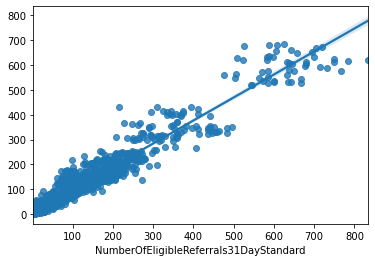

In [28]:
# check predictive power
sns.regplot(y_test,predictions)


print(stats)



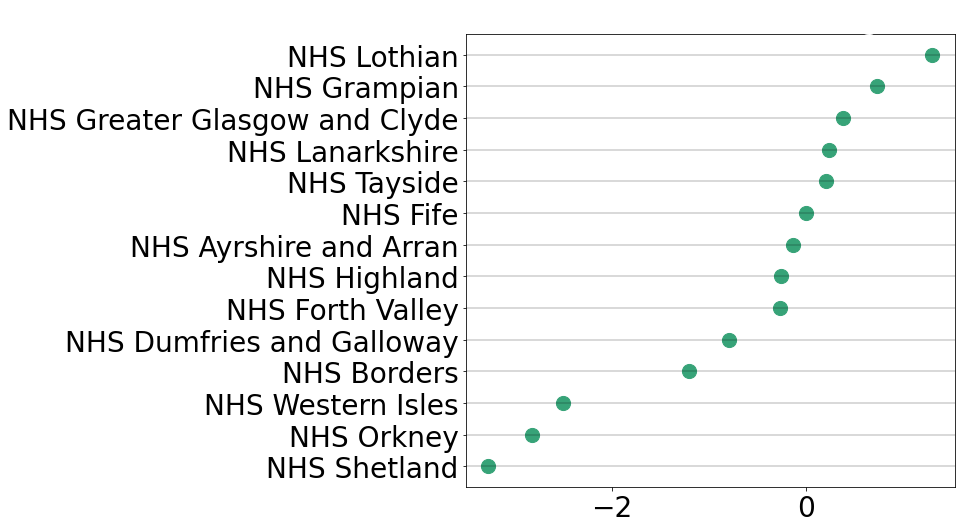

In [29]:
regions = ['NHS Shetland', 'NHS Orkney','NHS Western Isles', 'NHS Borders', 'NHS Dumfries and Galloway', 'NHS Forth Valley','NHS Highland','NHS Ayrshire and Arran', 
            'NHS Fife', 'NHS Tayside', 'NHS Lanarkshire', 'NHS Greater Glasgow and Clyde','NHS Grampian',  'NHS Lothian']

regions_nr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
coeff = [0]
coeff_all = list(np.asarray(coefficients)[10:,0])
new = coeff + coeff_all
new = sorted(new)

plt.rcParams['font.size']='28'

fig, ax = plt.subplots(1,1, figsize=(14,8))
plt.title('Coefficients for different regions', size=28, color='1')
plt.grid(color='k', linestyle='-', linewidth=0.3, axis='y')
plt.scatter(new, regions_nr, color=(55/255,163/255,120/255), s=200)
plt.yticks(regions_nr,regions)
#ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
fig.tight_layout()
plt.savefig('results/coefficients_regions.png')
plt.show()

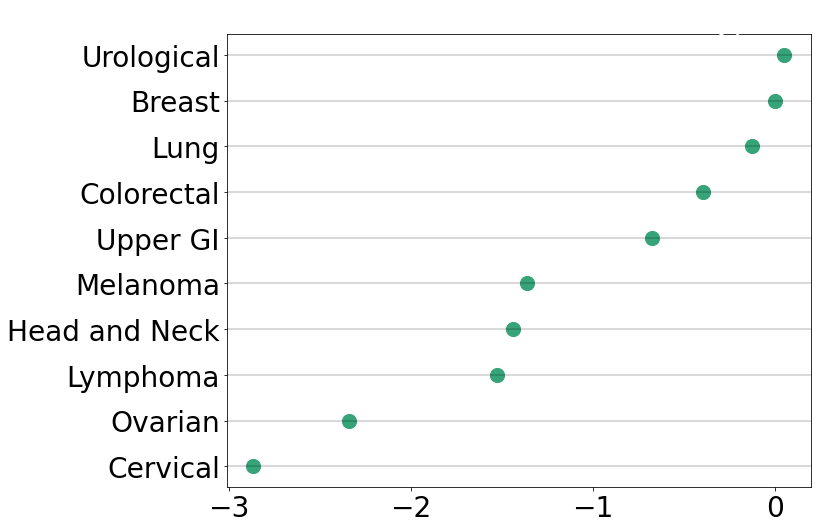

In [30]:
cancertypes = ['Cervical','Ovarian', 'Lymphoma', 'Head and Neck','Melanoma', 'Upper GI', 'Colorectal', 'Lung', 'Breast','Urological']

cancer_nr = [0,1,2,3,4,5,6,7,8,9]
coeff = [0]
coeff_all = list(np.asarray(coefficients)[1:10,0])
new = coeff + coeff_all
new = sorted(new)

fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.title('Coefficients for different cancer types', size=28, color='1')
plt.grid(color='k', linestyle='-', linewidth=0.3, axis='y')
plt.scatter(new, cancer_nr, color=(55/255,163/255,120/255), s=200)
plt.yticks(cancer_nr,cancertypes)
#ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
fig.tight_layout()
plt.savefig('results/coefficients_types.png')
plt.show()

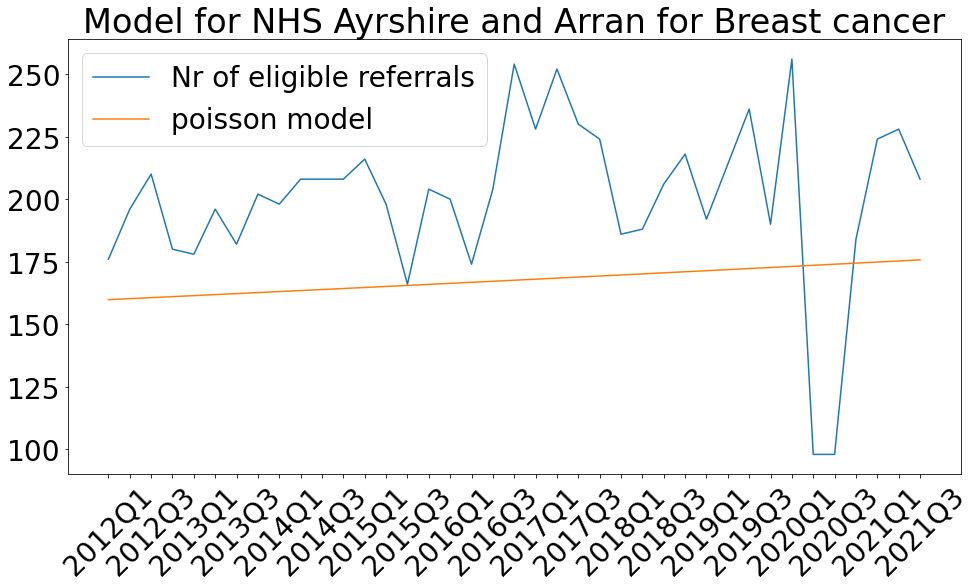

In [31]:
toplot = df[df['HB']=='S08000015']
toplot = toplot[toplot['CancerType']=='Breast']

b1 = coefficients.loc['Date', 'Coefficient']

fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.title('Model for NHS Ayrshire and Arran for Breast cancer')
plt.plot(np.asarray(toplot['Quarter']), np.asarray(toplot['NumberOfEligibleReferrals31DayStandard']), label='Nr of eligible referrals')
plt.plot(np.asarray(toplot['Quarter']), np.exp(intercept+np.asarray(toplot['Date'])*b1), label='poisson model')
ax.tick_params('x',labelrotation=45)
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.legend()
plt.savefig('results/poisson_breast.png')
plt.show()

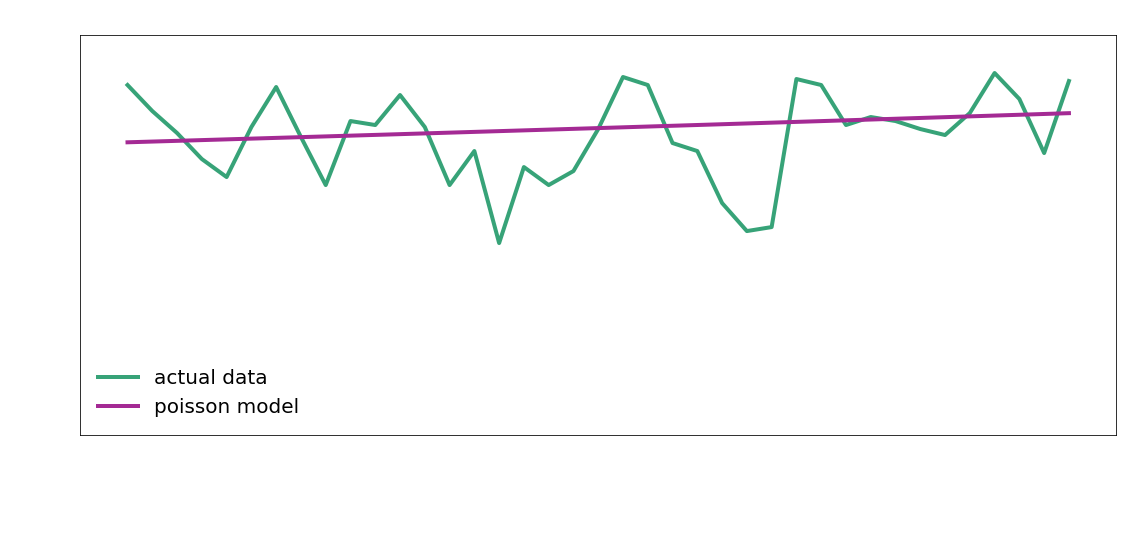

In [32]:
toplot = df[df['HB']=='S08000024']
toplot = toplot[toplot['CancerType']=='Lung']

b1 = coefficients.loc['Date', 'Coefficient']
b2 = coefficients.loc['HB_S08000024', 'Coefficient']
b3 = coefficients.loc['CancerType_Lung', 'Coefficient']

plt.rcParams['font.size']='20'
plt.rcParams['xtick.color'] = '1'
plt.rcParams['ytick.color'] = '1'
plt.rcParams['legend.frameon'] = 'False'

fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.title('Nr of referrals in NHS Lothian for lung cancer', size=28, color='1')
plt.plot(np.asarray(toplot['Quarter']), np.asarray(toplot['NumberOfEligibleReferrals31DayStandard']), label='actual data',linewidth=4, color=(55/255,163/255,120/255))
plt.plot(np.asarray(toplot['Quarter']), np.exp(intercept+np.asarray(toplot['Date'])*b1+b2+b3), label='poisson model',linewidth=4, color=(164/255,42/255,148/255))
ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Quarters', size=24, color='1')
plt.ylabel('Nr of referrals', size=24, color='1')
#plt.grid(color='k', linestyle='-', linewidth=0.3)
plt.legend(prop={'size':20}, labelcolor ='0')
fig.tight_layout()
plt.ylim([0,400])
plt.savefig('results/poisson_lung.png')
plt.show()

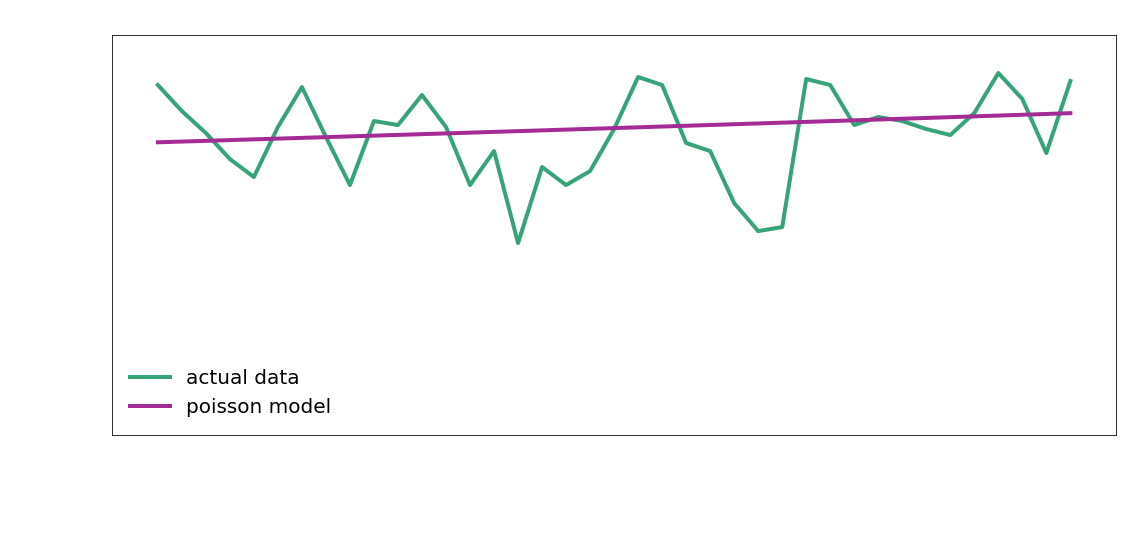

In [33]:
toplot = df[df['HB']=='S08000024']
toplot = toplot[toplot['CancerType']=='Lung']

b1 = coefficients.loc['Date', 'Coefficient']
b2 = coefficients.loc['HB_S08000024', 'Coefficient']
b3 = coefficients.loc['CancerType_Lung', 'Coefficient']

plt.rcParams['font.size']='20'
plt.rcParams['xtick.color'] = '1'
plt.rcParams['ytick.color'] = '1'
plt.rcParams['legend.frameon'] = 'False'

fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.title('Nr of referrals normalized by pop size in NHS Lothian for lung cancer', size=28, color='1')
plt.plot(np.asarray(toplot['Quarter']), np.asarray(toplot['NumberOfEligibleReferrals31DayStandard'])/800000, label='actual data',linewidth=4, color=(55/255,163/255,120/255))
plt.plot(np.asarray(toplot['Quarter']), np.exp(intercept+np.asarray(toplot['Date'])*b1+b2+b3)/800000, label='poisson model',linewidth=4, color=(164/255,42/255,148/255))
ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Quarters', size=24, color='1')
plt.ylabel('Nr of referrals/ population size', size=24, color='1')
#plt.grid(color='k', linestyle='-', linewidth=0.3)
plt.ylim([0,0.0005])
plt.legend(prop={'size':20}, labelcolor ='0')
fig.tight_layout()
plt.savefig('results/poisson_lung_popsize.png')
plt.show()

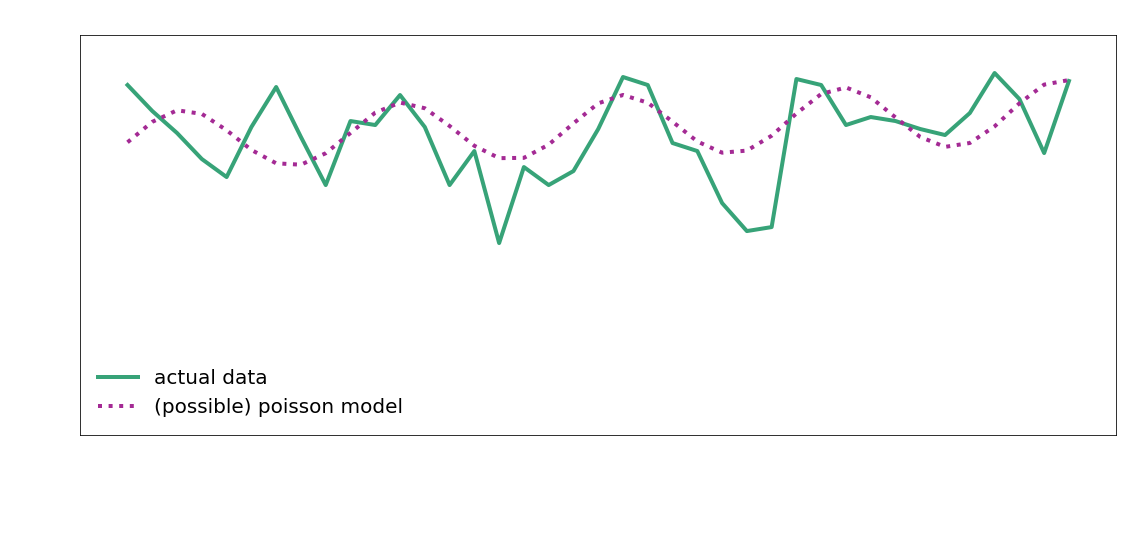

In [34]:
toplot = df[df['HB']=='S08000024']
toplot = toplot[toplot['CancerType']=='Lung']

b1 = coefficients.loc['Date', 'Coefficient']
b2 = coefficients.loc['HB_S08000024', 'Coefficient']
b3 = coefficients.loc['CancerType_Lung', 'Coefficient']
b4 = 1050
b5=0.1

plt.rcParams['font.size']='20'
plt.rcParams['xtick.color'] = '1'
plt.rcParams['ytick.color'] = '1'
plt.rcParams['legend.frameon'] = 'False'

fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.title('Nr of referrals in NHS Lothian for lung cancer', size=28, color='1')
plt.plot(np.asarray(toplot['Quarter']), np.asarray(toplot['NumberOfEligibleReferrals31DayStandard']), label='actual data',linewidth=4, color=(55/255,163/255,120/255))
plt.plot(np.asarray(toplot['Quarter']), np.exp(intercept+np.asarray(toplot['Date'])*b1+b5*np.sin(np.asarray(toplot['Date'])*b4)+b2+b3), \
                            label='(possible) poisson model',linewidth=4, color=(164/255,42/255,148/255), linestyle='dotted')
ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Quarters', size=24, color='1')
plt.ylabel('Nr of referrals', size=24, color='1')
#plt.grid(color='k', linestyle='-', linewidth=0.3)
plt.ylim([0,400])
plt.legend(prop={'size':20}, labelcolor ='0')
fig.tight_layout()
plt.savefig('results/poisson_lung_nonlinear.png')
plt.show()

In [35]:
# choose data
X=X0_dp
Y=Y0

# run poisson regression for chosen data
parameters, intercept, coefficients, y_test, predictions, stats = poissonR(X,Y,1)

/home/s2273096/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/s2273096/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


-0.010491537158236738


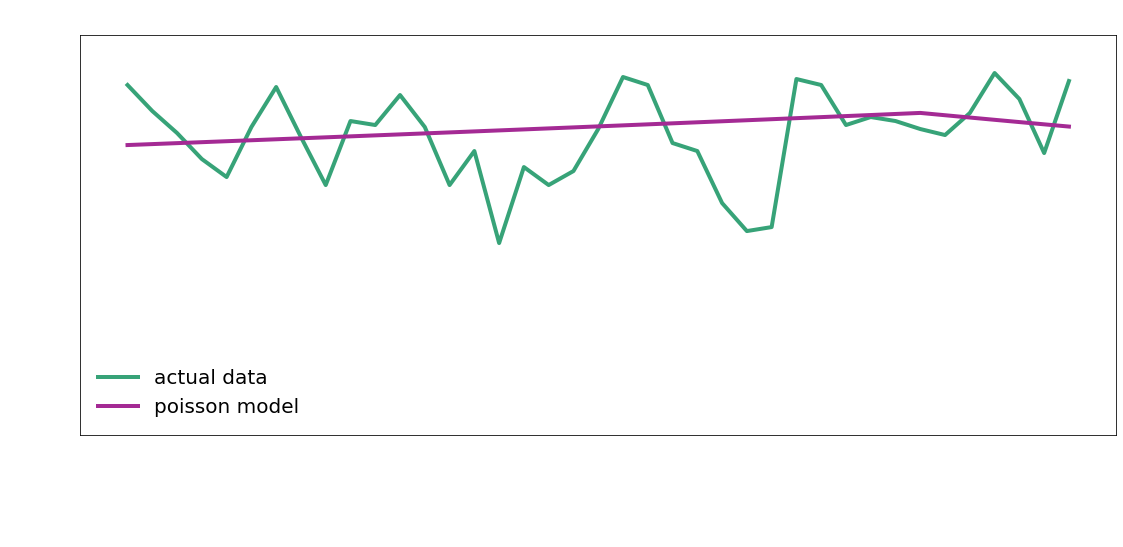

In [36]:
toplot = df[df['HB']=='S08000024']
toplot = toplot[toplot['CancerType']=='Lung']

b1 = coefficients.loc['Date', 'Coefficient']
b2 = coefficients.loc['HB_S08000024', 'Coefficient']
b3 = coefficients.loc['CancerType_Lung', 'Coefficient']
b4 = coefficients.loc['Pandemic', 'Coefficient']

print(b4)

plt.rcParams['font.size']='20'
plt.rcParams['xtick.color'] = '1'
plt.rcParams['ytick.color'] = '1'
plt.rcParams['legend.frameon'] = 'False'

fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.title('Nr of referrals in NHS Lothian for lung cancer', size=28, color='1')
plt.plot(np.asarray(toplot['Quarter']), np.asarray(toplot['NumberOfEligibleReferrals31DayStandard']), label='actual data',linewidth=4, color=(55/255,163/255,120/255))
plt.plot(np.asarray(toplot['Quarter']), np.exp(intercept+np.asarray(toplot['Date'])*b1+np.asarray(toplot['Pandemic'])*b4+b2+b3), label='poisson model',linewidth=4, color=(164/255,42/255,148/255))
ax.tick_params('x',labelrotation=45, color='1')
ax.set_facecolor('1')
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Quarters', size=24, color='1')
plt.ylabel('Nr of referrals', size=24, color='1')
#plt.grid(color='k', linestyle='-', linewidth=0.3)
plt.ylim([0,400])
plt.legend(prop={'size':20}, labelcolor='0')
fig.tight_layout()
plt.savefig('results/poisson_lung_pandemic.png')
plt.show()